In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

In [12]:
np.random.seed(12)

# asset = np.random.normal(mean, std, size)
asset_a = np.random.normal(0.001, 0.02, 252)
asset_b = np.random.normal(0.0008, 0.015, 252)
asset_c = np.random.normal(0.0012, 0.025, 252)

returns = pd.DataFrame({
    "assetA" : asset_a,
    "assetB" : asset_b,
    "assetC" : asset_c
})

Rf = 0.0001
def risk_parity_weights(returns):
    cov = returns.cov().values
    n = len(cov)

    def obj(w):
        sigma = np.sqrt(w @ cov @ w)
        rc = w * (cov @ w) / sigma
        return ((rc - sigma/n)**2).sum()

    cons = {'type':'eq', 'fun': lambda w: w.sum() - 1}
    bounds = [(0,1)] * n
    w0 = np.ones(n)/n

    return minimize(obj, w0, bounds=bounds, constraints=cons).x


def sharpe_ratio(w, r=returns, rf=Rf):
    portfolio_returns = r.dot(w)
    excess_return = portfolio_returns.mean() - rf
    portfolio_volatility = portfolio_returns.std()

    return (excess_return / portfolio_volatility) * np.sqrt(252)

def sortino_ratio(w, r=returns, rf=Rf):
    portfolio_returns = r.dot(w)
    excess_return = portfolio_returns.mean() - rf
    downs = portfolio_returns[portfolio_returns < 0]
    if len(downs) == 0:
      return np.nan
    portfolio_volatility = downs.std()

    return (excess_return / portfolio_volatility) * np.sqrt(252)

def cumulative_return(w, r=returns):
    portfolio_returns = r.dot(w)
    cum_growth = (1 + portfolio_returns).cumprod()

    return cum_growth.iloc[-1] - 1

def max_drawdown(w, r=returns):
    portfolio_returns = r.dot(w)
    cum_growth = (1 + portfolio_returns).cumprod()
    peak = cum_growth.cummax()
    drawdown = (cum_growth - peak) / peak

    return drawdown.min()

def portfolio_performance(w, r=returns):
  port_ret = r.dot(w)
  vol = port_ret.std() * np.sqrt(252)


  return {
        "Portfolio Return": port_ret.mean() * 252,
        "Portfolio Volatility": vol,
        "Sharpe": sharpe_ratio(w),
        "Sortino": sortino_ratio(w),
        "Cumulative Return": cumulative_return(w),
        "Max Drawdown": abs(max_drawdown(w))
  }

returns_mean = returns.mean()
returns_vol  = returns.std()
returns_corr = returns.corr()
returns_cov  = returns.cov()


w_equal = np.array([1/3,1/3,1/3])
inv_vol = 1 / returns_vol
w_inv =  inv_vol / inv_vol.sum()
w_rp = risk_parity_weights(returns)

results = {
    "Equal Weights": portfolio_performance(w_equal),
    "Inverse Volatility": portfolio_performance(w_inv),
    "Risk Parity": portfolio_performance(w_rp)
}

df = pd.DataFrame(results).T
print(df)

                    Portfolio Return  Portfolio Volatility    Sharpe  \
Equal Weights               0.046846              0.175037  0.123666   
Inverse Volatility          0.067796              0.161642  0.263519   
Risk Parity                 0.046846              0.175037  0.123666   

                     Sortino  Cumulative Return  Max Drawdown  
Equal Weights       0.202059           0.032090      0.119012  
Inverse Volatility  0.436300           0.056312      0.114598  
Risk Parity         0.202059           0.032090      0.119012  


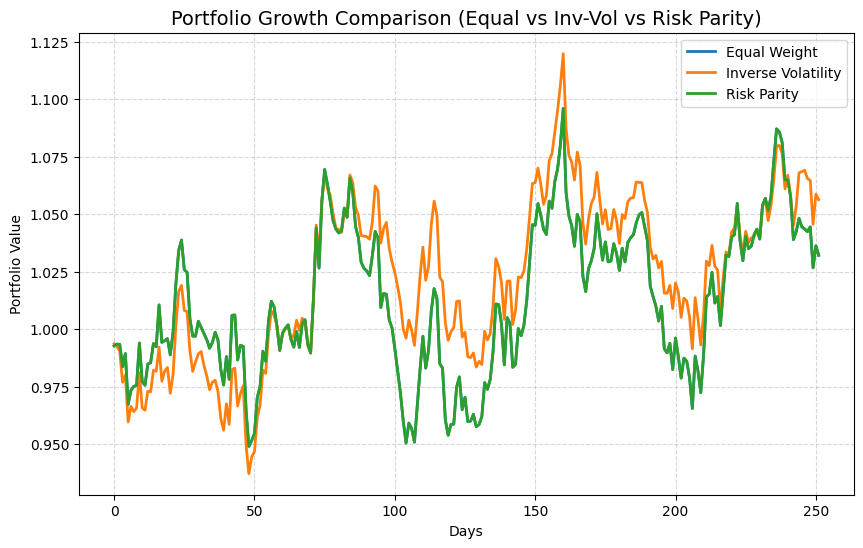

In [13]:

def cumulative_series(w, r=returns):
    """Return the full cumulative growth path, not just the final number."""
    port_ret = r.dot(w)
    return (1 + port_ret).cumprod()

cum_equal = cumulative_series(w_equal)
cum_inv   = cumulative_series(w_inv)
cum_rp    = cumulative_series(w_rp)

# --- Step 2: Plot cumulative performance ---
plt.figure(figsize=(10,6))

plt.plot(cum_equal, label="Equal Weight", linewidth=2)
plt.plot(cum_inv, label="Inverse Volatility", linewidth=2)
plt.plot(cum_rp, label="Risk Parity", linewidth=2)

plt.title("Portfolio Growth Comparison (Equal vs Inv-Vol vs Risk Parity)", fontsize=14)
plt.ylabel("Portfolio Value")
plt.xlabel("Days")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()